# Autoencoder 

**Creating an AE that can learn an information rich spectral profiles embeddings to reconstruct the image/spetrum**

In [ ]:
from pyimzml.ImzMLParser import ImzMLParser

p = ImzMLParser('../HIV.imzml')
my_spectra = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y, z)])

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model



# Use mzs as fixed reference, only reconstruct intensities
class SpectrumAutoencoder(Model):
    def __init__(self, latent_dim, n_peaks):
        super(SpectrumAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.n_peaks = n_peaks
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        # FIXED: Use linear activation for final layer instead of sigmoid
        # This works better with MSE loss and avoids saturation issues
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(n_peaks, activation='linear'),  # Changed from sigmoid to linear
        ])

    def call(self, intensities):
        encoded = self.encoder(intensities)
        decoded_intensities = self.decoder(encoded)
        return decoded_intensities

# AutoEncoder will be created after data preprocessing
# AutoEncoder = SpectrumAutoencoder(latent_dim=12,n_peaks=69)

In [26]:
# There will need to be some interpolation when icluding more points (see VAE Paper)


In [27]:
# Data preprocessing - convert all spectra to same length
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler

def preprocess_spectra(spectra_list, target_length=1000):
    """
    Preprocess spectra to have consistent length and normalize intensities
    """
    processed_intensities = []
    all_mzs = []
    
    # Collect all mz values to find common range
    for spectrum in spectra_list:
        mzs, intensities, _ = spectrum
        all_mzs.extend(mzs)
    
    # Create common mz grid
    min_mz, max_mz = min(all_mzs), max(all_mzs)
    common_mzs = np.linspace(min_mz, max_mz, target_length)
    
    # Interpolate all spectra to common grid
    for spectrum in spectra_list:
        mzs, intensities, _ = spectrum
        
        # Create interpolation function
        f = interp1d(mzs, intensities, kind='linear', 
                    bounds_error=False, fill_value=0)
        
        # Interpolate to common grid
        interpolated_intensities = f(common_mzs)
        processed_intensities.append(interpolated_intensities)
    
    # Convert to numpy array and normalize
    X = np.array(processed_intensities)
    
    # FIXED: Proper normalization to [0, 1] range for sigmoid activation
    X_min = X.min()
    X_max = X.max()
    X = (X - X_min) / (X_max - X_min + 1e-8)
    
    return X, common_mzs

# Preprocess the data
print(f"Total spectra: {len(my_spectra)}")
X_processed, common_mzs = preprocess_spectra(my_spectra, target_length=1000)
print(f"Processed data shape: {X_processed.shape}")
print(f"Data range: [{X_processed.min():.4f}, {X_processed.max():.4f}]")

Total spectra: 56678
Processed data shape: (56678, 1000)
Data range: [0.0000, 1.0000]
Processed data shape: (56678, 1000)
Data range: [0.0000, 1.0000]


In [28]:
# Split data into train and test sets
X_train, X_test = train_test_split(X_processed, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Create autoencoder with correct input dimension
latent_dim = 64  # Adjust as needed
input_dim = X_train.shape[1]  # Should be 1000 from preprocessing

autoencoder = SpectrumAutoencoder(latent_dim=latent_dim, n_peaks=input_dim)

# Compile the model
autoencoder.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for reconstruction
    metrics=['mae']  # Mean Absolute Error as additional metric
)

print(f"Autoencoder created with latent_dim={latent_dim}, input_dim={input_dim}")

Training set shape: (45342, 1000)
Test set shape: (11336, 1000)
Autoencoder created with latent_dim=64, input_dim=1000
Autoencoder created with latent_dim=64, input_dim=1000


In [29]:
# Training the autoencoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Check data before training
print(f"Training data stats:")
print(f"  Shape: {X_train.shape}")
print(f"  Min: {X_train.min():.6f}, Max: {X_train.max():.6f}")
print(f"  Mean: {X_train.mean():.6f}, Std: {X_train.std():.6f}")

# Train the model
print("Starting training...")
history = autoencoder.fit(
    X_train, X_train,  # Input and target are the same for autoencoder
    epochs=20,  # Increased epochs to see learning
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training completed!")

# Quick check after training
sample_pred = autoencoder(X_test[:1])
print(f"Sample prediction stats:")
print(f"  Min: {sample_pred.numpy().min():.6f}, Max: {sample_pred.numpy().max():.6f}")
print(f"  Mean: {sample_pred.numpy().mean():.6f}")

Training data stats:
  Shape: (45342, 1000)
  Min: 0.000000, Max: 1.000000
  Mean: 0.002274, Std: 0.008235
Starting training...
  Mean: 0.002274, Std: 0.008235
Starting training...
Epoch 1/20
Epoch 1/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 8.1973e-06 - mae: 0.0011 - val_loss: 3.8383e-06 - val_mae: 8.7757e-04 - learning_rate: 0.0010
Epoch 2/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 8.1973e-06 - mae: 0.0011 - val_loss: 3.8383e-06 - val_mae: 8.7757e-04 - learning_rate: 0.0010
Epoch 2/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 3.3163e-06 - mae: 8.3884e-04 - val_loss: 3.0481e-06 - val_mae: 8.2333e-04 - learning_rate: 0.0010
Epoch 3/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 3.3163e-06 - mae: 8.3884e-04 - val_loss: 3.0481e-06 - val_mae: 8.2333e-04 - learning_rate: 0.0010
Epoch 3/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 2.7011e-06 - mae: 7.8108e-04 - val_loss: 2.4866e-06 - val_mae: 7.3927e-04 - learning_rate: 0.0010
Epoch 

Test Loss (MSE): 0.000002
Test MAE: 0.000557


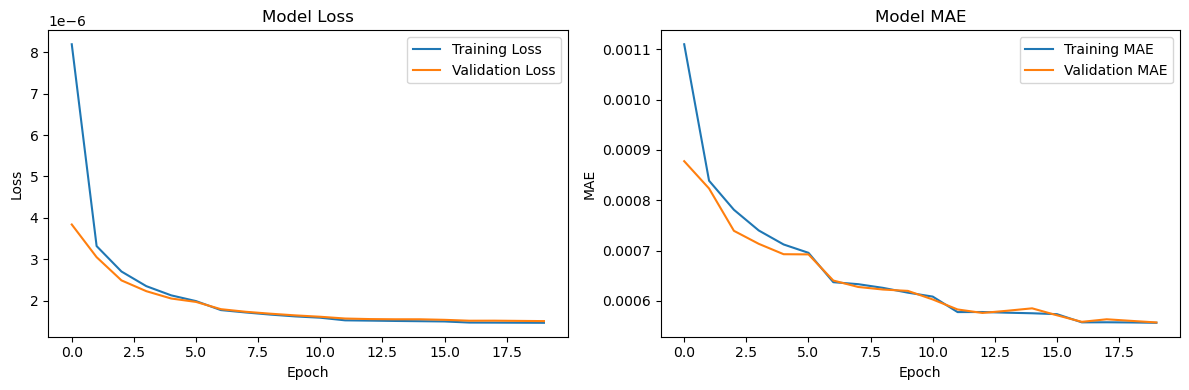

In [30]:
# Evaluate the model
test_loss, test_mae = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

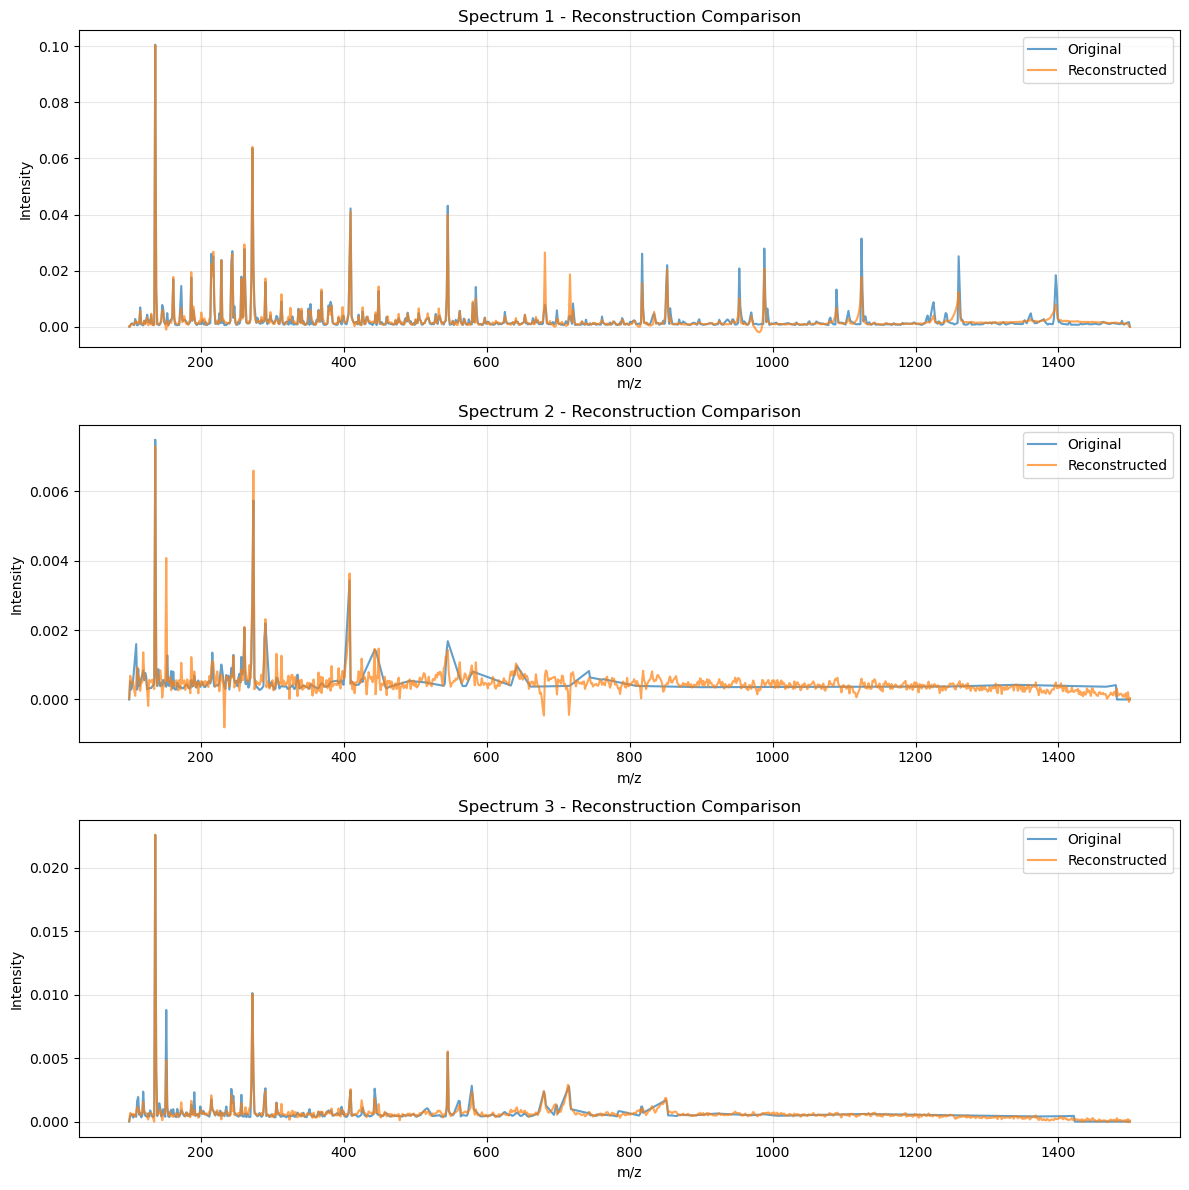

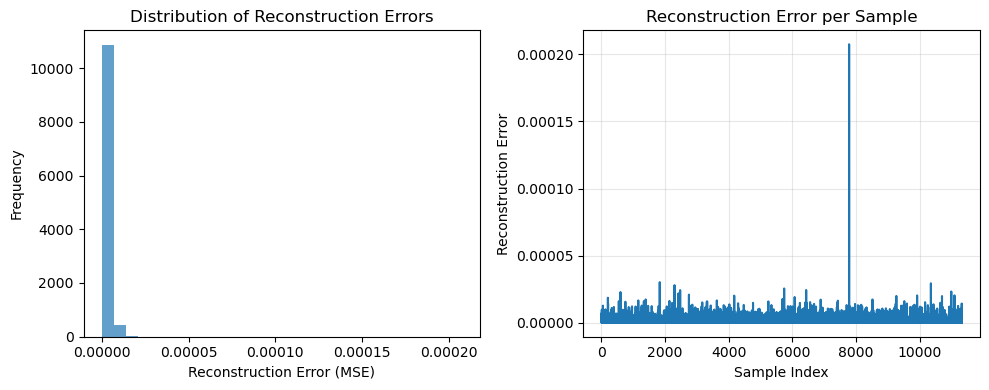

Mean reconstruction error: 0.000002
Std reconstruction error: 0.000003


In [31]:
# Visualize original vs reconstructed spectra
def plot_reconstruction_comparison(autoencoder, X_test, common_mzs, n_samples=3):
    """Plot original vs reconstructed spectra"""
    reconstructed = autoencoder(X_test[:n_samples])
    
    fig, axes = plt.subplots(n_samples, 1, figsize=(12, 4*n_samples))
    if n_samples == 1:
        axes = [axes]
    
    for i in range(n_samples):
        axes[i].plot(common_mzs, X_test[i], label='Original', alpha=0.7)
        axes[i].plot(common_mzs, reconstructed[i], label='Reconstructed', alpha=0.7)
        axes[i].set_xlabel('m/z')
        axes[i].set_ylabel('Intensity')
        axes[i].set_title(f'Spectrum {i+1} - Reconstruction Comparison')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot reconstructions
plot_reconstruction_comparison(autoencoder, X_test, common_mzs, n_samples=3)

# Show reconstruction error statistics
reconstructed_test = autoencoder(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructed_test), axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(reconstruction_errors, bins=30, alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')

plt.subplot(1, 2, 2)
plt.plot(reconstruction_errors)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error per Sample')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean reconstruction error: {np.mean(reconstruction_errors):.6f}")
print(f"Std reconstruction error: {np.std(reconstruction_errors):.6f}")

In [32]:
reconstructed

array([[4.11053508e-26, 1.35499321e-27, 6.11618158e-26, 4.13659611e-28,
        1.18843424e-25, 4.35901807e-25, 1.34546248e-22, 3.30503815e-26,
        1.25073742e-27, 2.71508593e-25, 1.78412712e-31, 3.25920912e-29,
        1.26876597e-30, 8.27314793e-28, 9.14268157e-26, 3.30927099e-22,
        2.78755922e-28, 7.20513750e-26, 6.28009578e-26, 8.28016633e-26,
        7.11566509e-31, 3.67568737e-27, 8.54995182e-26, 3.24937941e-28,
        5.48713551e-25, 8.28259423e-27, 1.25223666e-27, 4.83259858e-26,
        1.28285855e-25, 3.52465579e-26, 9.08901731e-27, 1.50719395e-26,
        3.07117552e-27, 1.31298009e-25, 1.23440924e-26, 6.20278680e-26,
        3.15366647e-25, 1.29989005e-22, 2.75808452e-25, 1.46209375e-26,
        1.98204444e-28, 7.27720487e-26, 1.76093899e-27, 2.62257202e-25,
        6.58504845e-26, 3.06409723e-26, 1.82069513e-26, 1.52585137e-25,
        2.76786699e-24, 6.26989142e-28, 9.04655135e-25, 7.28886303e-29,
        8.27330894e-27, 1.35287673e-25, 2.41065893e-26, 6.503902